In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DoubleType, DateType, TimestampType
import pyspark.sql.functions as spfunc 
from pyspark.sql.functions import year, month
from matplotlib import pyplot as plt 



In [4]:
spark = SparkSession.builder\
        .master("local")\
            .appName("StockAnalysis")\
                .getOrCreate()

df = spark.read.csv("csv/Netflix Dataset.csv", header=True, inferSchema=True)

print(df.printSchema())

df.show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

None
+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|2002-05-23|1.156429|1.242857|1.145714|1.196429| 1.196429|104790000|
|2002-05-24|1.214286|   1.225|1.197143|    1.21|     1.21| 11104800|
|2002-05-28|1.213571|1.232143|1.157143|1.157143| 1.157143|  6609400|
|2002-05-29|1.164286|1.164286|1.085714|1.103571| 1.103571|  6757800|
|2002-05-30|1.107857|1.107857|1.071429|1.071429| 1.071429| 10154200|
|2002-05-31|1.078571|1.078571|1.071429|1.076429| 1.076429|  8464400|
|2002-06-03|    1.08|1.149286|1.076429|1.128571| 1.128571|  3151400|
|2002-06-04|1.135714|    1.14|1.110714|1.

In [5]:
output = df.select(df.Date\
                    ,df.Open, df.Volume)\
        .where(df.Open < 1.15)\
        .orderBy(df.Date)

In [6]:
print("Df count: ", df.count())

print("Output count: ",output.count())

Df count:  5540
Output count:  180


In [7]:
output.createOrReplaceTempView("output")

In [8]:
spark.sql("select Date, Open from output").show()

+----------+--------+
|      Date|    Open|
+----------+--------+
|2002-05-30|1.107857|
|2002-05-31|1.078571|
|2002-06-03|    1.08|
|2002-06-04|1.135714|
|2002-06-05|1.110714|
|2002-06-10|   1.135|
|2002-06-13|1.104286|
|2002-06-14|1.082143|
|2002-06-17|1.013571|
|2002-06-18|0.938571|
|2002-06-19|0.911429|
|2002-06-20|0.971429|
|2002-06-21|0.982143|
|2002-06-24|0.979286|
|2002-06-25|0.988571|
|2002-06-26|0.963571|
|2002-06-27|1.009286|
|2002-06-28|0.960714|
|2002-07-01|     1.0|
|2002-07-02|1.053571|
+----------+--------+
only showing top 20 rows



In [34]:
yearly_df = df.withColumn("year", year(df["Date"]))\
.withColumn("month", month(df["Date"]))

In [48]:
avgs_per_year = yearly_df.groupBy("year").agg(spfunc.avg("close").alias("avg_close"))

open_avg_per_year = yearly_df.groupBy("year").agg(spfunc.avg("open").alias("avg_open"))

avgs_per_year = avgs_per_year.join(open_avg_per_year, "year").orderBy("year")

avgs_per_year.show()

+----+------------------+------------------+
|year|         avg_close|          avg_open|
+----+------------------+------------------+
|2002|0.8501716363636362|0.8559740064935066|
|2003|2.0812046626984118| 2.072242035714286|
|2004|3.4134296944444427| 3.424325400793648|
|2005|2.5972618809523786| 2.596978468253969|
|2006|  3.69099603187251| 3.692253852589639|
|2007| 3.123932856573706| 3.123733685258964|
|2008| 4.094669632411067| 4.087244462450594|
|2009| 6.322035134920639| 6.302471670634923|
|2010|  16.8241722936508|16.777222234126974|
|2011|27.493718773809533|27.499665468253962|
|2012|11.855057135999996|11.827480000000008|
|2013|35.271830920634905| 35.24976188095238|
|2014|57.495119063492076| 57.51611119047618|
|2015| 91.89567448809534| 91.79801591666669|
|2016|102.03035719841262|102.00051615873015|
|2017|165.37426305976106|165.40231063346616|
|2018| 319.2903190079681|319.62055821912367|
|2019| 328.8723800674604|328.63706417857134|
|2020| 446.8272328695651|446.14146189328073|
|2021| 558

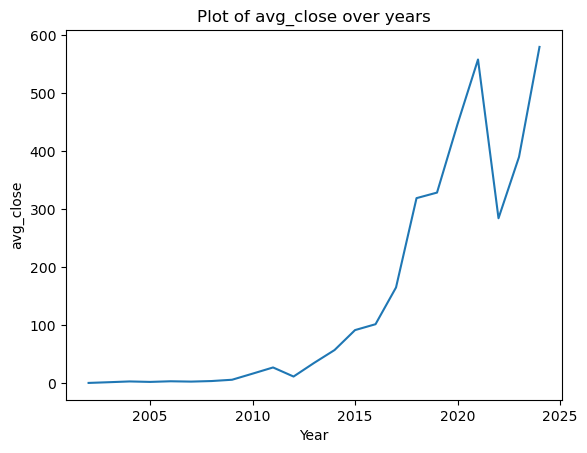

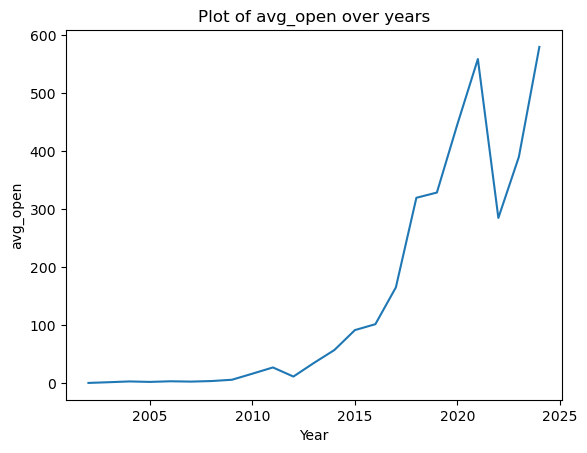

3442.4139955902237
3441.4772601112572


In [56]:
for col in avgs_per_year.columns:
    if col != 'year':
        x = avgs_per_year.select('year').rdd.flatMap(lambda x: x).collect()
        y = avgs_per_year.select(col).rdd.flatMap(lambda x: x).collect()
        plt.figure() 
        plt.plot(x, y)
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.title(f'Plot of {col} over years')
        plt.show()

print(avgs_per_year.select(spfunc.sum('avg_close')).collect()[0][0])
print(avgs_per_year.select(spfunc.sum('avg_open')).collect()[0][0])

DataFrame[Date: date]
